In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
#images = glob.glob('*.jpg')
for i in range(56,71,1):
    img = cv2.imread('IMG_54'+str(i)+'.jpg')
    #print('IMG_54'+str(i)+'.jpg')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    #print(ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
        cv2.imwrite('img'+str(i)+'.jpg',img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print(mtx)

[[1.36415094e+04 0.00000000e+00 3.31635881e+03]
 [0.00000000e+00 1.36632517e+04 1.50037396e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Projection Matrix is: [[ 4.46765428e+02  3.48582750e-01  8.65198264e+01  1.06140982e+03]
 [ 1.05129517e+00  4.42363080e+02  5.32162630e+01  5.88039323e+02]
 [ 1.52972824e-03 -3.34831460e-04  3.23769470e-02  1.00000000e+00]]
Camera Calibration Matrix is: [[1.36415094e+04 0.00000000e+00 3.31635881e+03]
 [0.00000000e+00 1.36632517e+04 1.50037396e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix  [[ 0.99888188  0.00329952 -0.0471605 ]
 [-0.00280852  0.9999412   0.01047375]
 [ 0.04719229 -0.01032959  0.99883241]]


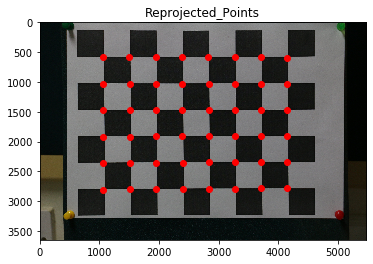

In [5]:
rotation_mat = np.zeros(shape=(3, 3))
projected_points=np.empty((48,3))
R = cv2.Rodrigues(rvecs[0], rotation_mat)[0]
P = np.column_stack((np.matmul(mtx,R),np.matmul(mtx,tvecs[0])))
P=P/P[2,3]
print('Projection Matrix is:',P)
print('Camera Calibration Matrix is:',mtx)
print('Rotation Matrix ',R)

for i in range(48):
    np.append(objpoints[0][i],1)
    projected_points[i]=np.matmul(P,np.append(objpoints[0][i],1))
    projected_points[i]=projected_points[i]/projected_points[i,2]

im=plt.imread('IMG_5456.jpg')
plt.plot(projected_points[:,0],projected_points[:,1],'ro')
plt.title('Reprojected_Points')
plt.imshow(im)
plt.show()


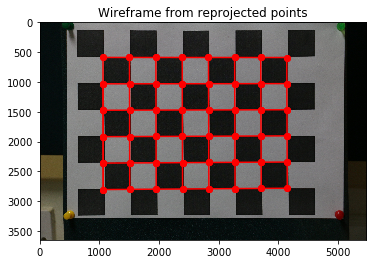

In [6]:
### Wireframe
idx = [7,15,23,31,39,47]
idx1 = [5,11,17,23,29,35,41,47]
q = 0
p = 0
for i in range(projected_points.shape[0]):
    if (i == idx[q]):
        q = q + 1
        continue
    plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'ro-')
for i in range(9):
    i1 = i
    j =  i + 8
    while(j < 48):
        plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'ro-')
        i1 = j
        j = j + 8
plt.imshow(im)
plt.savefig('Wireframe.jpg')
plt.title('Wireframe from reprojected points')
plt.show() 


In [76]:
print('The world origin is:',objpoints[0][0])
print('The projection of world origin is:',projected_points[0,:2],'pixels')

The world origin is: [0. 0. 0.]
The projection of world origin is: [1061.40981578  588.03932323] pixels


The Radial Distortion Parameters are 
 [[ 9.79057908e-02  9.45876425e+00 -1.53012034e-02  2.72096493e-02
  -1.48434591e+02]]


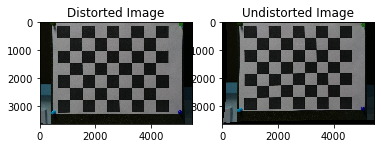

In [7]:
# Undistorting the image

im = cv2.imread('IMG_5456.jpg')
h,w = im.shape[: 2 ]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h), 1 ,(w,h))
print( "The Radial Distortion Parameters are \n" ,dist)
# undistort
img_undistorted = cv2.undistort(im, mtx, dist, None , newcameramtx)
plt.subplot( 121 )
plt.imshow(im)
plt.title( "Distorted Image" )
plt.subplot( 122 )
plt.imshow(img_undistorted)
plt.title( "Undistorted Image" )
plt.savefig('Planar_Undistort.jpg')